<font size=7> Latencies Analysis

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,  \
                                 plot_latency_dist_hist, plot_latency_angle_hist
from human_hip.animate import animate_latencies

In [2]:
sd = read_phy_files( "/workspaces/human_hippocampus/data/ephys/2022-11-02-e-Hc11.1-chip16753/derived/kilosort2/hc11.1_plated-11.1_chip-16753_rec_11.2.22AM-immediate_curated.zip" )


In [4]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc
import numpy as np
from human_hip.spike_data import latencies, cross_sttc

def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=30, sttc_cutoff = 0.04, latency_cutoff=2.5, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  #latency= np.median(pair_latencies)
        if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
        #if stats.ttest_1samp(pair_latencies,0)[1]<.1 and len(pair_latencies)>25:
            #pairs_late.append( pair )  #lags_late.append( latency )
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>25:
                    pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )
            else:
                pairs_late.append( pair ) 

    pairs= pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    ##Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs: 
        sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
        max_args = np.argwhere(sttcs == np.amax(sttcs)) - 1000 
        cross_lag.append( max_args[np.argmin(np.abs(max_args))][0] )   # if multiple maxima, take the one closest to zero
    cross_lag = np.array(cross_lag)
    to_keep = np.where(( cross_lag< cross_sttc_max_cutoff) & (cross_lag> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")
    return np.array(pairs)[ to_keep ] 



In [5]:
good_pairs = curate_latencies(sd)
# with open( 'hc111_good_pairs.pkl' , 'wb') as my_file:
#     pickle.dump(good_pairs, my_file)
#load pickled data
# with open( 'hc111_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)
# len(good_pairs)

7569 Starting Pairs
329 pairs above sttc cutoff
67 pairs above latencency cutoff
Starting cross_sttc calculation... might take a minute
57 pairs between cross_sttc cutoffs


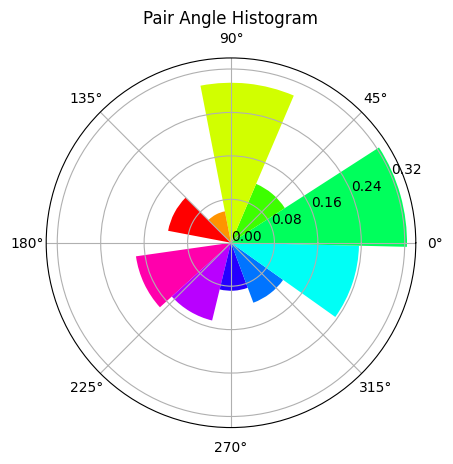

In [5]:
plot_latency_angle_hist( sd, good_pairs)

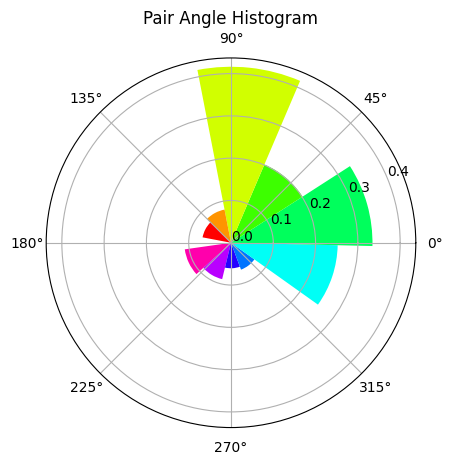

In [6]:
plot_latency_angle_hist(sd, good_pairs, by_firing_rate=True, late_cutoff_high=30)

# Vector Plots

In [5]:
plot_vector_layout

<function human_hip.spike_data.plot_latencies.plot_vector_layout(sd, pairs, normalize=True, arrow_length=75, min_dist=0, image_path=None, xlim=None, ylim=None)>

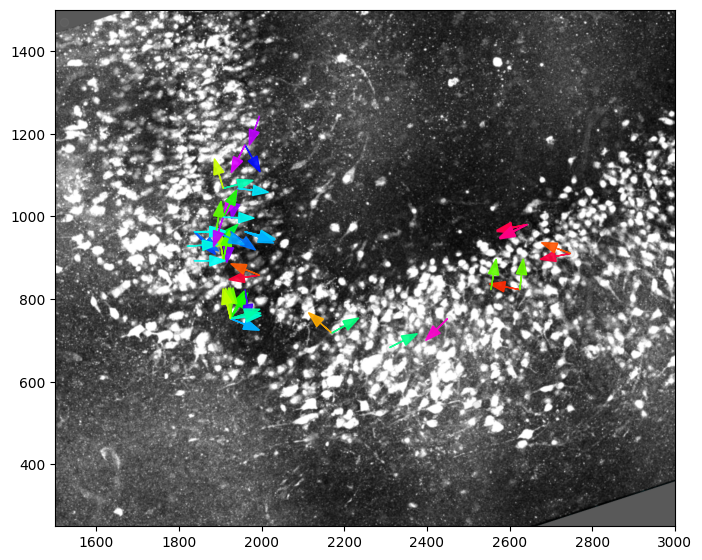

In [7]:
plot_vector_layout( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc111_bw.png", xlim=(1500,3000), ylim=(250,1500))

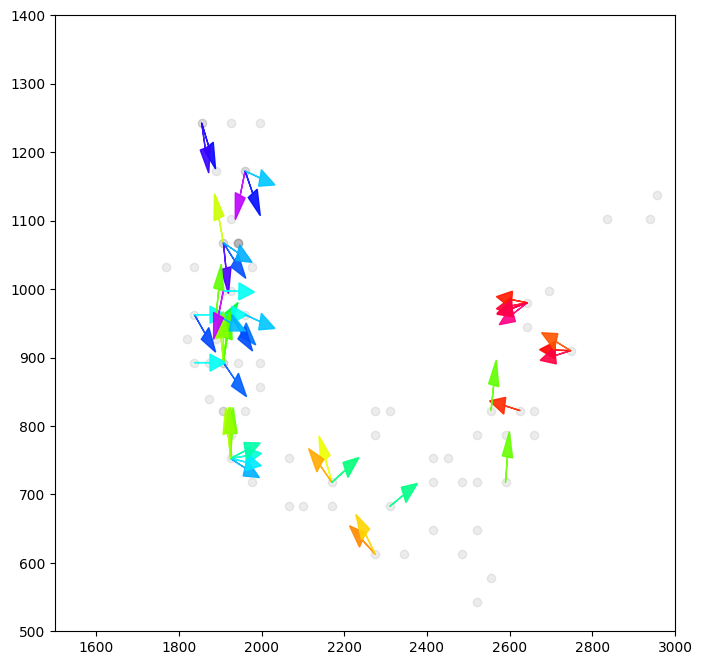

In [11]:
plot_vector_layout( sd, good_pairs, xlim=(1500,3000), ylim=(500,1400) )

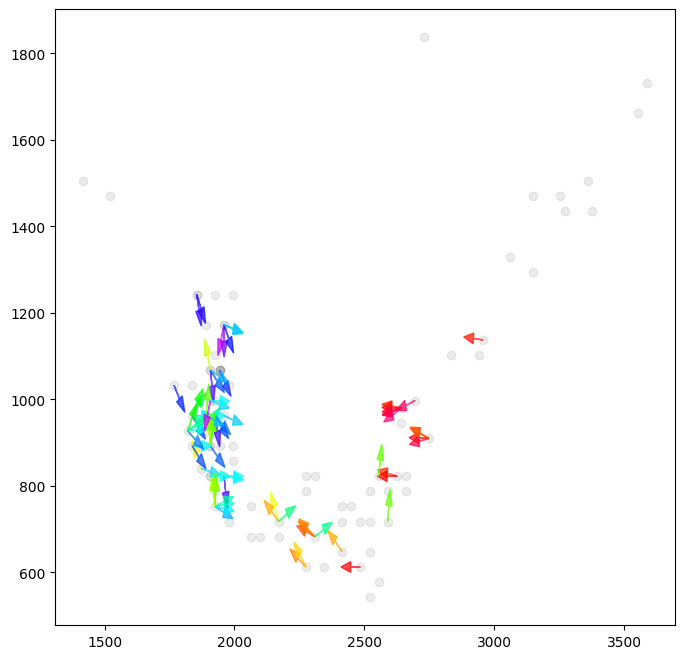

In [5]:
plot_vector_layout( sd, good_pairs)

In [8]:
from ipywidgets import interact_manual, interact
import matplotlib.pyplot as plt
from scipy import stats

def pairs_hisogram(pairs, sd, ms_cutoff_high=30):
    @interact
    def plot_pair(pair_i = (0, len(pairs)-1) ):
        latencies_pair = latencies( pairs[pair_i,0], pairs[pair_i,1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("Latency Mean:\t", np.mean(latencies_pair ) )

        t_stat, p_value = stats.ttest_1samp( latencies_pair, 0)
        one_sided_p_value = p_value / 2 if t_stat > 0 else 1 - p_value / 2
        print("T-Test 1-Side:\t", one_sided_p_value )  #print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )

pairs_hisogram( good_pairs, sd, ms_cutoff_high=30)

interactive(children=(IntSlider(value=28, description='pair_i', max=56), Output()), _dom_classes=('widget-inte…